In [1]:
# Import numpy and matplotlib, and use jupyter magic to
# get plots directly in notebook
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

# These two lines set nicer looking defaults for matplotlib
import seaborn as sns
sns.set(style='ticks', palette='Set1')

## Storing data

In [2]:
# This is just to illustrate the benefit of storing data
# in a binary format instead of text files.
# For small files, text is often convenient, but for larger
# amounts of data, the benefits of binary formats are important:
# reading and writing data is significantly faster, and files
# are much smaller.

# Generate some random numbers
N = 100000
r = np.random.normal(size = N, loc = 0, scale = 1000)

In [3]:
# Store as a text file, using numpy's built in savetxt function.
# If you open the file in a text editor, you will see it is
# simply a text file with one number on each line.
np.savetxt('random.txt', r)

In [4]:
# Store as a binary file, using numpy's built in save function.
# Notice the difference in speed between the two ways of storing
# data, and compare the file size of the two files.
np.save('random.npy', r)

## HDF5

In [5]:
# Minimal example with HDF5
import h5py as h5
# Generate some random numbers
N = 100000
r = np.random.normal(size = N, loc = 0, scale = 1000)

# To write data
f = h5.File('random.h5', 'w') # 'w' opens the file in write mode
d = f.create_dataset('random', data = r)
f.close()

In [6]:
# To read data
f = h5.File('random.h5', 'r') # 'r' opens the file in write mode
r = f.get('random')
# r is now an hdf5 dataset type, using array indexing to 
# get values. Use r[:] to get the entire array.
print(r[0:10])
f.close()

[ -466.83826635  1369.83202021  1147.7716365   -990.81120373 -1316.63793037
   273.38777991  -313.93096897 -1136.47993119  1204.38432119 -1468.49252802]


## NetCDF

In [7]:
# Minimal example with NetCDF
import netCDF4 as nc
# Generate some random numbers
N = 100000
r = np.random.normal(size = N, loc = 0, scale = 1000)

# NetCDF is somewhat more involved to write than HDF5,
# because you have to create dimensions before you can
# store variables. For example, if you want to store
# values of electric field in a plane, you have to 
# define the x and y dimensions first.

# In this case, we will store a rank-1 array (r), so we
# need one dimension. Let's say our array of random
# numbers is actually a signal, as a function of time:

# This creates and opens the file random.nc in write mode.
d = nc.Dataset('random.nc', 'w')
# Create time-dimension, with name 't' and size len(r)
t = d.createDimension('t', len(r))
# The arguments to createVariable are name, datatype
# and name of dimension(s)
v = d.createVariable('random', r.dtype, ('t',))
# Note the use of array indexing to fill variable with data.
# If you simply say v = r, v will stop being of the type 
# NetCDF variable, and become a numpy array instead.
v[:] = r
d.close()

In [8]:
# To read data (much simpler than writing)
d = nc.Dataset('random.nc', 'r')
r = d.variables['random']
# r is now a NetCDF variable type, using array indexing to 
# get values. Use r[:] to get the entire array.
print(r[0:10])
d.close()

[ -766.74924563   798.12440285 -1630.56095969   102.96237343 -1609.73556746
   869.21566758    33.68867173   979.46617284   490.48061991  -225.77112009]


## Plotting data from a NetCDF file on a map

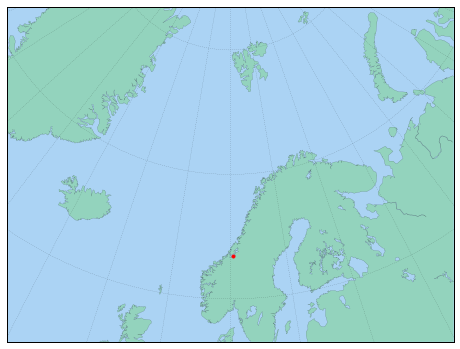

In [9]:
# This is an example of how to plot data from NetCDF
# files hosted at met.no, on a map, using python and 
# the basemap library.

# This requires installing basemap. How to do that
# will depend on your setup. One of these might work:
# pip install basemap --allow-external basemap --allow-unverified basemap
# conda install basemap

# Import basemap
from mpl_toolkits.basemap import Basemap

# Set figsize
fig = plt.figure(figsize = (8, 6))

# Define some colors and variables, and create a map.
seacolor  = (171/255, 211/255, 244/255)
landcolor = (147/255, 211/255, 189/255)
lat_0  = 70
lon_0  = 10
width  = 4000000
height = 3000000
m = Basemap(
    lat_0      = lat_0,   # Latitude at center of map
    lon_0      = lon_0,   # Longitude at center of map
    width      = width,   # Width of map (in meters)
    height     = height,  # Height of map (in meters)
    resolution = 'l',     # Resolution of coastlines, 'l' is 'low'
    projection = 'stere'  # Map projection, 'stere' is 'stereographic'
)

linewidth = 0.1
alpha     = 0.5
# Fill background with seacolor.
m.drawmapboundary(fill_color=seacolor)
# Fill continents with landcolor, and lakes with seacolor.
m.fillcontinents(color=landcolor, lake_color=seacolor)
# Draw coastlines with a thin black line.
m.drawcoastlines(linewidth = linewidth)
# Draw grid of parallels and meridians, at every 10 degrees.
m.drawparallels(np.arange(-90.,91.,10.), linewidth = linewidth, alpha = alpha)
m.drawmeridians(np.arange(-180.,181.,10.), latmax = 90, linewidth = linewidth, alpha = alpha)

# m is now an object that can draw things on a map.
# It can also convert coordinates, so we can plot
# data in latitude and longitude. Example: Plot a
# ret dot over Trondheim.

# Convert from lon-lat to x-y (internal plot coordinates),
# using the map object:
x, y = m(10.393333, 63.429722)
# s is the size, zorder is the 'z-coordinate' in the layers
# that make up the plot. The continents are at zorder 1, so
# the marker must be 2, or it will be hidden behind the land.
m.scatter(x, y, marker = '.', color = 'r', s = 50, zorder = 2)

In [10]:
# One of the really neat things about NetCDF is that
# it is possible to host these files on a server, in
# such a way that you can open the remote files as if
# they were local, and only download the data you need.

# Open a datafile with ocean data hosted at met.no:
d = nc.Dataset('http://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m/NorKyst-800m_ZDEPTHS_avg.an.2016021812.nc')
# Print the names of all the variables in the file
for v in d.variables:
    print(v)

X
Y
depth
forecast_reference_time
polar_stereographic
time
aice
h
hice
latitude
longitude
mask
salinity
temperature
u
ubar
v
vbar
zeta


In [11]:
# The data in the file are on a grid. Each point in the grid
# have a time, a longitude, a latitude (and a depth for some).
# Let's plot the surface temperature. First, we need to check
# the dimensions:
print(d.variables['temperature'].dimensions)

('time', 'depth', 'Y', 'X')


Converting coordinates
Plotting temperature


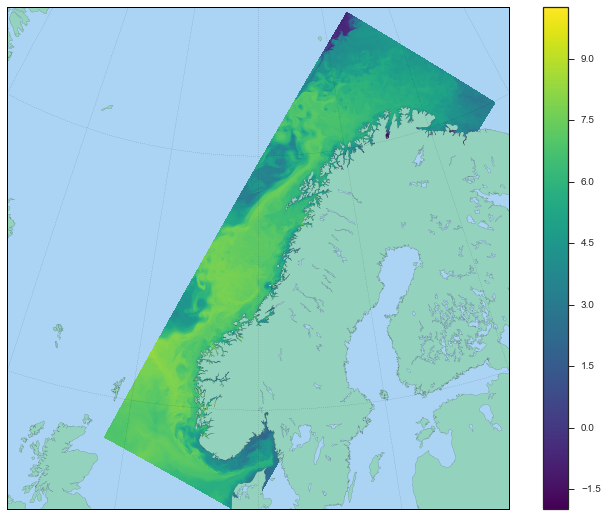

In [12]:
# Creating a new map, covering a smaller area

# Set figsize
fig = plt.figure(figsize = (12, 9))

# Define some colors and variables, and create a map.
seacolor  = (171/255, 211/255, 244/255)
landcolor = (147/255, 211/255, 189/255)
lat_0  = 66
lon_0  = 10
width  = 2200000
height = 2200000
m = Basemap(
    lat_0      = lat_0,   # Latitude at center of map
    lon_0      = lon_0,   # Longitude at center of map
    width      = width,   # Width of map (in meters)
    height     = height,  # Height of map (in meters)
    resolution = 'i',     # Resolution of coastlines, 'i' is intermediate
    projection = 'stere'  # Map projection, 'stere' is 'stereographic'
)

linewidth = 0.1
alpha     = 0.5
# Fill background with seacolor
m.drawmapboundary(fill_color=seacolor)
# Fill continents with landcolor, and lakes with seacolor
m.fillcontinents(color=landcolor, lake_color=seacolor)
# Draw coastlines with a thin black line
m.drawcoastlines(linewidth = linewidth)
# draw grid of parallels and meridians.
m.drawparallels(np.arange(-90.,91.,10.), linewidth = linewidth, alpha = alpha)
m.drawmeridians(np.arange(-180.,181.,10.), latmax = 90, linewidth = linewidth, alpha = alpha)

# Done creating new map


# Get the data for the first timestep, the first (upper) depth,
# and all longitudes and latitudes.
# Only at this point do we actually download data, so this can
# take a little while (usually not more than some seconds).
print('Downloading temperature')
temp = d.variables['temperature'][0, 0, :, :]

# Then we need the longitudes and latitudes of each point, 
# in order to place the grid correctly on the map. This can
# also take some seconds.
print('Downloading coordinates')
lons = d.variables['longitude'][:,:]
lats = d.variables['latitude'][:,:]

# Convert from lon-lat to internal plot coordinates:
print('Converting coordinates')
x, y = m(lons, lats)
# Plot as a heatmap, this can also take a while,
# up to half a minute or so:
print('Plotting temperature')
mesh = m.pcolormesh(x, y, temp, cmap = 'viridis')
plt.colorbar(mesh)

# To store the plot as an image, use 
# plt.savefig('map.png', dpi = 300')